## Feature Engineering

This stage builds on the preprocessed and encoded datasets created in **Sprint 1** (`training_encoded.csv`, `test_encoded.csv`).  
The goal is to enrich the feature space with **domain-driven, low-cardinality features** that capture behavioral patterns, vaccine attitudes, and health vulnerability while remaining compatible with the existing encodings.

### Load and Inspect the Encoded Data

We begin by loading the baseline encoded datasets from `data/processed/`.  
These contain all categorical encodings (ordinal, one-hot, and target-encoded columns) and numeric features after imputation.

Purpose:
- Provide a clean, fully numeric feature base.
- Avoid handling raw categorical values or missing-value logic again.

In [1]:
import pandas as pd
from pathlib import Path

import sys, os
repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)
    
from src.feature_engineering import engineer_all_features

# --- 1. Load encoded data ---
train_path = Path("../data/interim/training_encoded.csv")
test_path = Path("../data/interim/test_encoded.csv")

train_encoded = pd.read_csv(train_path)
test_encoded = pd.read_csv(test_path)

print(f"Loaded: {train_encoded.shape[0]} train rows, {test_encoded.shape[0]} test rows")

Loaded: 26707 train rows, 26708 test rows



### Apply Feature Engineering Functions

We apply a modular pipeline implemented in `src/feature_engineering.py`, composed of several functions:

##### `add_behavioral_features(df)`

Creates **aggregate indices** from behavioral and opinion-based variables:
- **PBI (Preventive Behavior Index):**  
  Mean of all 7 behavioral indicators → represents how preventive a respondent’s habits are.
- **PVAS_h1n1 / PVAS_seas (Pro-Vaccine Attitude Scores):**  
  Combine vaccine effectiveness, risk, and side-effect opinions into compact attitude metrics.
- **HKI (Health Knowledge Index):**  
  Average of `h1n1_concern` and `h1n1_knowledge`, capturing awareness level.
- **doctor_any:**  
  Binary flags showing whether any doctor recommended vaccination.

These features summarize behavioral tendencies and trust in vaccination.

---

##### `add_socioeconomic_flags(df)`

Generates interpretable **binary indicators** from categorical socioeconomic variables (which include `"Missing"` values):
- `below_poverty` – whether income is coded as “Below Poverty”.
- `low_edu` – lower education (`< 12 Years` or `12 Years`).
- `housing_insecure` – renting or missing housing status.
- `no_job` – unemployed or missing employment status.
- `no_insurance` – missing health insurance.
- `is_married` – marital stability proxy.
- `is_senior` – respondent aged 65+.

These features are robust against “Missing” imputations and help characterize access barriers.

---

##### `add_health_risk_index(df)`

Builds a **Health Risk Index (HRI)** by combining medical and demographic risk factors:

$$
\text{HRI} = \text{chronic\_med\_condition} + \text{child\_under\_6\_months} + \text{health\_worker} + \text{is\_senior} + \text{below\_poverty}
$$

- The result is clipped to 0–4.  
- A higher score implies greater health vulnerability or priority for vaccination.

---

##### `add_interactions(df)`

Adds a small number of **interpretable interaction features** that combine behavior, attitude, and access:
- `PVASxPBI_h1n1` – relationship between attitude and preventive behavior.
- `PVASxDoctor_seas` – influence of doctor recommendation on seasonal vaccine attitude.
- `PBIxNoInsur` – proactive individuals lacking insurance.
- `SeniorxChronic` – elderly people with chronic conditions.
- `PovertyxRent` – compounding economic and housing vulnerability.
- `industry_occ_te_mean` – average of the two target encodings for industry and occupation.

These interactions model joint effects that can be critical for both **vaccine adoption prediction** and **public health targeting**.

---

##### `engineer_all_features(df)`

Combines all previous functions into one clean pipeline:
```python
df.pipe(add_behavioral_features)
  .pipe(add_socioeconomic_flags)
  .pipe(add_health_risk_index)
  .pipe(add_interactions)


In [2]:
# --- 2. Apply feature engineering ---
train_fe = engineer_all_features(train_encoded)
test_fe = engineer_all_features(test_encoded)

print(f"New shapes: {train_fe.shape}, {test_fe.shape}")

New shapes: (26707, 74), (26708, 74)


In [3]:
# --- 3. Inspect new columns ---
new_cols = [c for c in train_fe.columns if c not in train_encoded.columns]
print("Added features:", new_cols)

Added features: ['PBI', 'PVAS_h1n1', 'PVAS_seas', 'HKI', 'doctor_any', 'below_poverty', 'low_edu', 'housing_insecure', 'no_job', 'no_insurance', 'is_married', 'is_senior', 'HRI', 'PVASxPBI_h1n1', 'PVASxDoctor_seas', 'PBIxNoInsur', 'SeniorxChronic', 'PovertyxRent', 'industry_occ_te_mean']


In [4]:
# Load targets
labels = pd.read_csv("../data/raw/training_set_labels.csv")

# Merge into the engineered training data
train_fe = train_fe.copy()
train_fe["h1n1_vaccine"] = labels["h1n1_vaccine"]
train_fe["seasonal_vaccine"] = labels["seasonal_vaccine"]

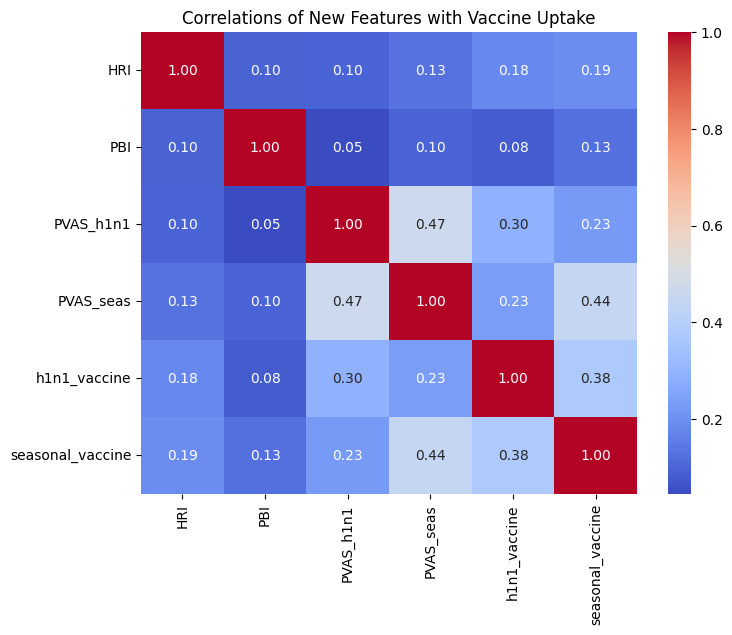

In [5]:
# Check correlation between new indices and vaccine uptake
import seaborn as sns
import matplotlib.pyplot as plt

corr_targets = train_fe[["HRI", "PBI", "PVAS_h1n1", "PVAS_seas"] + ["h1n1_vaccine", "seasonal_vaccine"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_targets, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlations of New Features with Vaccine Uptake")
plt.show()

### Validate Engineered Features

After generating all new features, we perform a **validation check** to ensure data quality and consistency before saving the enhanced datasets.

The validation function `validate_engineered_features(df)` performs several automatic tests:

| Validation | Description |
|:--|:--|
| **Feature presence check** | Confirms that all expected engineered columns (e.g., `PBI`, `PVAS_h1n1`, `HRI`, etc.) exist in the dataset. |
| **Numeric type enforcement** | Ensures every engineered feature is numeric: no string or categorical values remain. |
| **Missing value check** | Verifies that none of the engineered features contain `NaN` values after processing. |
| **Range checks** | Confirms logical bounds for key indices:<br>– `PBI` ∈ [0, 1]<br>– `HRI` ∈ [0, 4] |
| **Console confirmation** | Prints `Feature validation passed: all checks OK.` if everything is valid. |

This step guarantees that the engineered dataset is safe for downstream modeling and that no invalid values were introduced during feature creation.

In [6]:
from src.feature_engineering import validate_engineered_features

# Validate engineered training dataset
validate_engineered_features(train_fe)

# Optional: test dataset validation
validate_engineered_features(test_fe)


Feature validation passed: all checks OK.
Feature validation passed: all checks OK.


#### Save Full Feature Set

After validating the engineered data, we export the final datasets:

- **`training_fe.csv` / `test_fe.csv`**  
  Contain **all original encoded features** plus the **new engineered features** (indices, flags, and interactions).

In [7]:
train_fe.to_csv("../data/interim/training_fe.csv", index=False)
test_fe.to_csv("../data/interim/test_fe.csv", index=False)

#### Feature Engineering Outcomes

| Category             | New Features                                   | Purpose                        |
| :------------------- | :--------------------------------------------- | :----------------------------- |
| Behavioral / Opinion | PBI, PVAS_h1n1, PVAS_seas, HKI                 | Capture habits and attitudes   |
| Socioeconomic Flags  | below_poverty, low_edu, housing_insecure, etc. | Describe access barriers       |
| Health Risk          | HRI                                            | Identify high-risk individuals |
| Interactions         | PVASxPBI_h1n1, SeniorxChronic, etc.            | Model combined effects         |
| Encoded Mean         | industry_occ_te_mean                           | Aggregate occupational signal  |

These engineered features bridge the gap between predictive modeling and actionable insights, enabling:

- Identification of vulnerable groups for targeted health interventions.
- Discovery of high-conversion segments for commercial vaccination campaigns.

### Summary of Engineered Features

| **Feature Group** | **Feature Names** | **Purpose / What They Capture** | **Key Rationale** |
|:--|:--|:--|:--|
| **Behavioral Indices** | `PBI` | Preventive health habits | Summarizes multiple binary behavior variables into a single scale (0–1). |
| **Attitude Scores** | `PVAS_h1n1`, `PVAS_seas` | Vaccine trust & perceived risk | Compact representation of effectiveness, risk, and side-effect opinions. |
| **Knowledge Index** | `HKI` | Awareness & concern | Combines concern and knowledge into a general awareness score. |
| **Doctor Recommendation Flags** | `doctor_any`, `doctor_gap` | Exposure (or lack) to professional vaccine advice | Indicates whether a doctor recommended at least one vaccine (kept only `doctor_any` for modeling). |
| **Socioeconomic Flags** | `below_poverty`, `low_edu`, `housing_insecure`, `no_job`, `no_insurance`, `is_married`, `is_senior` | Economic & demographic constraints | Capture access barriers and key sociodemographic traits. |
| **Health Risk Index** | `HRI` | Composite health vulnerability measure | Quantifies clinical and demographic risk factors (0–4 scale). |
| **Interaction Features** | `PVASxPBI_h1n1`, `PVASxDoctor_seas`, `PBIxNoInsur`, `SeniorxChronic`, `PovertyxRent` | Combined behavior–attitude or risk–access effects | Capture non-linear relationships relevant to uptake decisions. |
| **Aggregated Target Encodings** | `industry_occ_te_mean` | Occupation–industry vaccination tendency | Smooth summary of both target-encoded job features. |

---

## Feature Formulas (Reference)

1. **Preventive Behavior Index (PBI)**
$$
\mathrm{PBI} \;=\; \frac{1}{7}\sum_{i=1}^{7} \text{behavioral}_{i}
$$

2. **Pro-Vaccine Attitude Scores (PVAS)**
$$
\mathrm{PVAS}_{\mathrm{h1n1}} \;=\; \frac{\text{opinion\_h1n1\_vacc\_effective} + \text{opinion\_h1n1\_risk} - \text{opinion\_h1n1\_sick\_from\_vacc}}{3}
$$
$$
\mathrm{PVAS}_{\mathrm{seas}} \;=\; \frac{\text{opinion\_seas\_vacc\_effective} + \text{opinion\_seas\_risk} - \text{opinion\_seas\_sick\_from\_vacc}}{3}
$$

3. **Health Knowledge Index (HKI)**
$$
\mathrm{HKI} \;=\; \frac{\text{h1n1\_concern} + \text{h1n1\_knowledge}}{2}
$$

4. **Doctor Recommendation Flags**
$$
\text{doctor\_any} \;=\; (\text{doctor\_recc\_h1n1}=1) \;\lor\; (\text{doctor\_recc\_seasonal}=1)
$$
$$
\text{doctor\_gap} \;=\; 1 - \text{doctor\_any}
$$

5. **Health Risk Index (HRI)**
$$
\mathrm{HRI} \;=\; \text{chronic\_med\_condition} + \text{child\_under\_6\_months} + \text{health\_worker} + \text{is\_senior} + \text{below\_poverty}
$$

6. **Key Interactions**
$$
\text{PVASxPBI}_{\mathrm{h1n1}} \;=\; \mathrm{PVAS}_{\mathrm{h1n1}} \times \mathrm{PBI}
\qquad
\text{PVASxDoctor}_{\mathrm{seas}} \;=\; \mathrm{PVAS}_{\mathrm{seas}} \times \text{doctor\_any}
$$
$$
\text{PBIxNoInsur} \;=\; \mathrm{PBI} \times \text{no\_insurance}
\qquad
\text{SeniorxChronic} \;=\; \text{is\_senior} \times \text{chronic\_med\_condition}
$$
$$
\text{PovertyxRent} \;=\; \text{below\_poverty} \times \text{rent\_or\_own\_Rent}
$$

7. **Industry–Occupation Mean Target Encoding**
$$
\text{industry\_occ\_te\_mean} \;=\; \frac{\text{employment\_industry\_te\_h1n1} + \text{employment\_industry\_te\_seasonal}}{2}
$$

### Plain-text
- **PBI** = (behavioral_1 + … + behavioral_7) / 7  
- **PVAS_h1n1** = (opinion_h1n1_vacc_effective + opinion_h1n1_risk − opinion_h1n1_sick_from_vacc) / 3  
- **PVAS_seas** = (opinion_seas_vacc_effective + opinion_seas_risk − opinion_seas_sick_from_vacc) / 3  
- **HKI** = (h1n1_concern + h1n1_knowledge) / 2  
- **doctor_any** = (doctor_recc_h1n1 == 1) OR (doctor_recc_seasonal == 1)  
- **doctor_gap** = 1 − doctor_any  
- **HRI** = chronic_med_condition + child_under_6_months + health_worker + is_senior + below_poverty  
- **PVASxPBI_h1n1** = PVAS_h1n1 × PBI; **PVASxDoctor_seas** = PVAS_seas × doctor_any  
- **PBIxNoInsur** = PBI × no_insurance; **SeniorxChronic** = is_senior × chronic_med_condition  
- **PovertyxRent** = below_poverty × rent_or_own_Rent  
- **industry_occ_te_mean** = (employment_industry_te_h1n1 + employment_industry_te_seasonal) / 2


---

**Result:**  
A compact, interpretable feature set that condenses behavioral, attitudinal, socioeconomic, and medical information into actionable predictors for both modeling accuracy and real-world decision support.
